# <center>Stock Market Price Prediction  
   <center>predcit the S&P500 index using sentiment analyst and machine learning models

### **Table of Contents**

1. [About This Project](#About-This-Project)
2. [Web Scraping](#Web-Scraping)
3. [Sentiment Analyst](#Sentiment-Analyst)  
4. [Data Preparation](#Data-Preparation) 
5. [Feature Engineering](#Feature-Engineering)
6. [EDA and Visualization](#EDA-and-Visualization)
   - [Correlations](#Correlations)
7. [Data Preprocessing](#Data-Preprocessing)
8. [Models](#Models)
   - [Linear Regression](#Linear-Regression)
   - [Ridge Regression](#Ridge-Regression)
   - [Lasso Regression](#Lasso-Regression)
   - [Random Forest Regression](#Random-Forest-Regression)
   - [Elastic Net Regression](#Elastic-Net-Regression)
   - [Support Vector Regression (SVM)](#Support-Vector-Regression-(SVM))
   - [XBoost](#XBoost)
   - [LSTM](#LSTM)
   - [Models Evaluation](#Models-Evaluation)

## <center>About This Project
    
The volatile and complex nature of the stock market, the constant volatility and uncertainty in it attract
Many experts and investors attempt to predict the future value of stocks and financial instruments.
Predicting the performance of the stock market is one of the most difficult things to do. Internal market volatility
The stock makes the forecasting task complex and challenging. Many variables affect the ability to predict
They include physical, technical factors and rational and irrational behavior. All these aspects become together
Stock prices are volatile, volatile and very difficult to predict with a high degree of accuracy.  
In this project I am trying to implement an approach of using machine learning models to predict the S&P500 index close price.  
To get as many features as possible that are correlative with the closing price, I chose to base myself on historical stock data, technical indicators and news headlines.  

**The data includes:**
* **Historical financial data:**
   I used yfinance library to collect financial daily data(Open,High,Low,Close and Volume) between the dates 01.01.2016 and 31.12.2022.  
  
  
* **News Headline:** I used web scraping to extract  s&p500 daily news headline between the dates 01.01.2016 and 31.12.2022.  
   In total I collected (using bot I wrote) 14,680 news headline for each day between the above dates (on average 8-10 headlines per day ). For each day I calculated an average sentiment score (using FinBert) - positive, negative or neutral and  received three additional features.


* **Technical indicators:** technical indicator is a mathematical calculation based on historic price, volume, or (in the case of futures contracts) open interest information that aims to forecast financial market direction. I added 18 features - technical indicators. As will be seen later, most of them are highly correlated with the closing price.  

The total data included daily data of 7 years and 28 features.  
After adding the features, analyzing the data, checking correlations, normalizing and deal with Skewed Features, I uesd machine learning regression models to  predict the Close price.

**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

from plotly import graph_objs as go
from datetime import date,timedelta,datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.metrics import mean_squared_error, r2_score #model evaluation
from sklearn.linear_model import LinearRegression , Ridge, Lasso, ElasticNet
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from statsmodels.formula.api import quantreg
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from IPython.display import Image
warnings.filterwarnings('ignore')

## <center>Web Scraping 

In [2]:
# Set scraping_run_cell to control whether this cell will be executed or skipped
# I chose to set this variable because the cell performs web scraping,
# which can be a time-consuming process. By default, scraping_run_cell is set to False
# to skip the execution of this cell when running the entire notebook.
# This allows me to save time when testing or rerunning the notebook.
# If you want to run this cell and perform the web scraping, you can manually
# change the value of scraping_run_cell to True.

scraping_run_cell = False

In [3]:
from requests_html import HTMLSession
import time
from datetime import date,timedelta,datetime
from tqdm import tqdm

def link_setting(tiker,start_date,end_date):
    urls=[]
    root="https://www.google.com/search?q="
    section1="+stock+price&biw=1536&bih=750&source=lnt&tbs=cdr%3A1%2"
    
    start_date=datetime.strptime(start_date,'%Y-%m-%d').date()
    end_date=datetime.strptime(end_date,'%Y-%m-%d').date()
    while start_date<=end_date:
        date=start_date
        section2="Ccd_min%3A"+str(date.month)+"%2F"+str(date.day)+"%2F"+str(date.year)+"%2Ccd_max%3A"+str(date.month)+"%2F"+str(date.day)+"%2F"+str(date.year)+"&tbm=nws"
        url=root+str(tiker)+section1+section2
        urls.append([url,tiker,date.strftime("%m/%d/%Y")])
        if start_date < end_date:
            start_date=start_date+timedelta(1)
        else:
            break
    return urls

def news_scraping(urls):
    count=0
    for url in tqdm(urls):
        count=count+1
        if count%40==0:
            time.sleep(10)
        if count==500:
            time.sleep(120)
        link=url[0]
        tiker_name=url[1]
        date=url[2]
        r=s.get(link) 
        items=r.html.find('a.WlydOe')
        for item in items:
            headline_list.append([tiker_name,date,item.find('span,ltr')[1].text.split('...')[0],link])
    data=pd.DataFrame(headline_list,columns=['Ticker Name','Date','News Headline','Links'])
    return data

s=HTMLSession()
headline_list=[]
urls=link_setting('S%26P+500 index',"2016-01-01","2022-01-31")

if scraping_run_cell:
    headline_data=news_scraping(urls)
    headline_data.to_csv('S&P500_headlines.csv')

## <center>Sentiment Analyst 

In [4]:
#Set sentiment_run_cell to control whether this cell will be executed or skipped
# I chose to set this variable because the cell performs sentiment analysis,
# which can be a computationally intensive process. By default, sentiment_run_cell is set to False
# to skip the execution of this cell when running the entire notebook.
# This allows me to save time when testing or rerunning the notebook.
# If you want to run this cell and perform the sentiment analysis, you can manually
# change the value of sentiment_run_cell to True.

sentiment_run_cell=False

In [5]:
if sentiment_run_cell:
    import torch as torch
    import swifter
    from ipywidgets import FloatProgress
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import time
    
    headlines_df=pd.read_csv("S&P500_headlines.csv")
    headlines_df=headlines_df.drop(['Links'],axis=1)
    headlines_df['Ticker Name'] ='S&P500 index'
    
    # create a tokenizer object
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    # fetch the pretrained model 
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    
    def sentiment(headline):
        # Pre-process input phrase
        input = tokenizer(headline, padding = True, truncation = True, return_tensors='pt')
        # Run inference on the tokenized phrase
        output = model(**input)

        # Pass model output logits through a softmax layer.
        sentim_scores = torch.nn.functional.softmax(output.logits, dim=-1)
        return(sentim_scores)

    sentiment_scores = headlines_df['News Headline'].swifter.apply(lambda x: sentiment(x))
    headlines_df['Positive'] = sentiment_scores.swifter.apply(lambda x: x[0][0].tolist())
    headlines_df['Negative'] = sentiment_scores.swifter.apply(lambda x: x[0][1].tolist())
    headlines_df['Neutral'] = sentiment_scores.swifter.apply(lambda x: x[0][2].tolist())
    headlines_df.to_csv("s&p500_sentiment score.csv")

## <center>Data Preparation

In [6]:
sp500 =  yf.Ticker("^GSPC").history(start='2016-01-01', end='2022-12-31')
sentimet_data=pd.read_csv("s&p500_sentiment score.csv")

In [7]:
sp500.head()

Open         High          Low        Close  \
Date                                                                            
2016-01-04 00:00:00-05:00  2038.199951  2038.199951  1989.680054  2012.660034   
2016-01-05 00:00:00-05:00  2013.780029  2021.939941  2004.170044  2016.709961   
2016-01-06 00:00:00-05:00  2011.709961  2011.709961  1979.050049  1990.260010   
2016-01-07 00:00:00-05:00  1985.319946  1985.319946  1938.829956  1943.089966   
2016-01-08 00:00:00-05:00  1945.969971  1960.400024  1918.459961  1922.030029   

                               Volume  Dividends  Stock Splits  
Date                                                            
2016-01-04 00:00:00-05:00  4304880000        0.0           0.0  
2016-01-05 00:00:00-05:00  3706620000        0.0           0.0  
2016-01-06 00:00:00-05:00  4336660000        0.0           0.0  
2016-01-07 00:00:00-05:00  5076590000        0.0           0.0  
2016-01-08 00:00:00-05:00  4664940000        0.0           0.0

In [8]:
sentimet_data.head()

Ticker Name        Date  \
0  S&P500 index  01/01/2016   
1  S&P500 index  01/01/2016   
2  S&P500 index  01/01/2016   
3  S&P500 index  02/01/2016   
4  S&P500 index  02/01/2016   

                                       News Headline  Positive  Negative  \
0               The Best Mutual Funds to Buy in 2016  0.165660  0.012516   
1  Believe It or Not, YouTube May Spend More on C...  0.076450  0.031935   
2  Munich Police Probe Terror Links as Railroad S...  0.025943  0.606367   
3              What Happened to the S&P 500 in 2015?  0.024164  0.445024   
4  Saudi Arabia Executes 47, Including Prominent ...  0.019008  0.841955   

    Neutral  
0  0.821824  
1  0.891615  
2  0.367690  
3  0.530813  
4  0.139037

After downloading the relevant news headlines and getting a sentiment score for each headline, we'll want to calculate an average sentiment score for each day.It should be noted that the data we downloaded from the yahoo directory does not necessarily contain information for every day in the requested date range.  
Therefore, first we extract from the table that contains the news headlines(sentimet_data) only the records of those days that exist in the table that contains financial data(sp500).For these records, an average sentiment score is calculated for each day and we will get three features that will be used to predict the closing price - an average positive, negative and neutral sentiment score.  
Then we will combine the 2 tables so that we get one table that contains daily financial data and average sentiment scores for each day.  
The following function receives the above 2 tables, calculates average sentiment scores for the days that overlap both and returns one table that will include all features

In [9]:
def avg_sentiment_score(fin_df,news_df):
    #Creating a new table that will contain the average scores for each day
    new_df = news_df.copy(deep=True).head(0)  # just take the  news df structure with no data inside
    new_df = new_df.drop(columns=['News Headline','Ticker Name'])  # drop irrelevant rrelevant headline column
    
    #Later, the merging of the tables will be done according to date. The extraction of the relevant rows from the news table will be done according to a comparison between the dates in fin_df and table news_df.
    #The date formats in the two tables are different, so it is first necessary to add a column to table fin_df that will have dates in the same format that appears in table news_df.
    #In addition, the name of the index in table fin_df must be changed so that it will not be the same as the name of the Date column according to which we would like to do the merger.
    
    fin_df.index.names = ['date']
    dates=pd.DataFrame(fin_df.index)
    dates_list=dates['date'].apply(lambda x:datetime.strftime(x, '%d-%m-%Y')).apply(lambda x: x.replace('-','/') ).tolist()
    fin_df['Date']=dates_list
    
    #Calculating  an  average sentiment score for each day
    for date in dates_list:
        sub_df = news_df[news_df['Date'] == date]  # filter specific dates
        avg_positive = sub_df['Positive'].mean()
        avg_negative = sub_df['Negative'].mean()
        avg_neutral = sub_df['Neutral'].mean()
        new_df.loc[len(new_df)]=[date,avg_positive, avg_negative, avg_neutral]
    
    
    fin_df['Index'] = fin_df.index #save the index before merging
    merged_df = fin_df.merge(new_df, on='Date', how='inner')
    merged_df=merged_df.set_index('Index')
    merged_df = merged_df.drop(columns=['Date'])
    
    return(merged_df)

In [10]:
sp500_data=avg_sentiment_score(sp500,sentimet_data)

During the development of my stock price prediction model, I consciously opted not to incorporate the low and high prices of the predicted day. This choice was motivated by the possibility of  <span style='color:Red'>data leakage</span>. It's important to note that both the low and high prices, much like the closing price, become available only at the end of the trading day. As a result, including these values in the prediction process could potentially introduce a form of inadvertent data leakage, wherein future information influences the model's accuracy. By refraining from utilizing the low and high prices of the predicted day, I aimed to maintain the model's predictive integrity, ensuring a more authentic representation of real-world forecasting scenarios. In my dashbord(you can see it on the git too) i do use low and high prices of the predicted day becouse it based on real-time data.

In [11]:
sp500_data['High']=sp500_data['High'].shift()
sp500_data['Low']=sp500_data['Low'].shift()

In [12]:
sp500_data.drop(index=sp500_data.index[0], axis=0, inplace=True)

In [13]:
sp500_data.head()

Open         High          Low        Close  \
Index                                                                           
2016-01-05 00:00:00-05:00  2013.780029  2038.199951  1989.680054  2016.709961   
2016-01-06 00:00:00-05:00  2011.709961  2021.939941  2004.170044  1990.260010   
2016-01-07 00:00:00-05:00  1985.319946  2011.709961  1979.050049  1943.089966   
2016-01-08 00:00:00-05:00  1945.969971  1985.319946  1938.829956  1922.030029   
2016-01-11 00:00:00-05:00  1926.119995  1960.400024  1918.459961  1923.670044   

                               Volume  Dividends  Stock Splits  Positive  \
Index                                                                      
2016-01-05 00:00:00-05:00  3706620000        0.0           0.0  0.115637   
2016-01-06 00:00:00-05:00  4336660000        0.0           0.0  0.225683   
2016-01-07 00:00:00-05:00  5076590000        0.0           0.0  0.125712   
2016-01-08 00:00:00-05:00  4664940000        0.0           0.0  0.154819   
2016-01-11 00:00:00-05:00  4607290000        0.0           0.0  0.328493   

                           Negative   Neutral  
Index                                          
2016-01-05 00:00:00-05:00  0.237990  0.646373  
2016-01-06 00:00:00-05:00  0.227760  0.546557  
2016-01-07 00:00:00-05:00  0.558511  0.315777  
2016-01-08 00:00:00-05:00  0.399601  0.445580  
2016-01-11 00:00:00-05:00  0.074144  0.597363

## <center>Feature Engineering    
Technical indicators are a set of tools applied to a trading chart to help make the market analysis clearer for the traders.
For example, technical indicators confirm if the market is following a trend or if the market is in a range-bound situation.
Also, indicators can provide specific market information such as when an asset is overbought or oversold in a range, and due for a reversal. 

<span style='color:Red'>Important Note:</span> Most of the original formulas use the closing price of a stock. To avoid leakage, I changed the formulas so that some do not use the closing price at all and some use the closing price of previous days.  

There are a lot of indicators that can be used, but I chose to use some common ones and add them as features:

**1. Simple Moving Average-SMA**  
Moving Averages are used to smooth the data in an array to help eliminate noise and identify trends. The Simple Moving        Average is literally the simplest form of a moving average. Each output value is the average of the previous n values. In a Simple Moving Average, each value in the time period carries equal weight, and values outside of the time period are not included in the average. This makes it less responsive to recent changes in the data, which can be useful for filtering out those changes. 

<img src="sma.png" alt="Alt Text" style="float: left; margin-right: 10px;" />

**2.Exponential Moving Average-EMA**  
The Exponential Moving Average is a staple of technical analysis and is used in countless technical indicators. In a Simple Moving Average, each value in the time period carries equal weight, and values outside of the time period are not included in the average. However, the Exponential Moving Average is a cumulative calculation, including all data. Past values have a diminishing contribution to the average, while more recent values have a greater contribution. This method allows the moving average to be more responsive to changes in the data.    
   *I choose to calaculate the SMA and the EMa for 3,7,14,50 and 150 days*  
   

**3. Bollinger Bands**  
   Bollinger Bands consist of three lines. The middle band is a simple moving average (generally 20 periods) of the typical    price (TP). The upper and lower bands are number of standard deviations (generally 2) above and below the middle band. The bands widen and narrow when the volatility of the price is higher or lower, respectively.    
Main Components of a Bollinger Bands:   
   * Upper Band: The upper band is simply two standard deviations above the moving average of a stock’s price.  
   * Middle Band: The middle band is simply the moving average of the stock’s price.  
   * Lower Band: Two standard deviations below the moving average is the lower band.    

<img src="bollinger bands.png" alt="Alt Text" style="float: left; margin-right: 20px; width: 400px; height: 250px;" />

**4. Commodity Channel Index (CCI)**  
   Commodity Channel Index (CCI) is a momentum-based oscillator used to help determine when an investment vehicle is reaching a    condition of being overbought or oversold. It is also used to assess price trend direction and strength.

<img src="cci.png" alt="Alt Text" style="float: left; margin-right: 20px; width: 350px; height: 250px;" />

**5. William’s %R**  
   Williams %R, also known as the Williams Percent Range, is a type of momentum indicator that moves between 0 and -100 and        measures overbought and oversold levels.

   The Williams %R may be used to find entry and exit points in the market.  

<img src="%r.png" alt="Alt Text" style="float: left; margin-right: 20px; width: 300px; height: 250px;" />

**6.  Stochastic %K**  
    A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices     over a certain period of time. It compares a close price and its price interval during a period of n past days and gives a     signal meaning that a stock is oversold or overbought.  


**7.Money Flow Index-MFI**  
The Money Flow Index (MFI) is the momentum indicator that is used to measure the inflow and outflow of money over a          particular time period.  
MFI is calculated by accumulating the positive and negative Money Flow values and then it creates the money ratio.  

<img src="mfi.png" alt="Alt Text" style="float: left; margin-right: 20px; width: 600px; height: 300px;" />

**8.The Average True Range (ATR):**  
   * The average true range (ATR) is a market volatility indicator used in technical analysis.
   * It is typically derived from the 14-day simple moving average of a series of true range indicators.
   * ATR shows investors the average range prices swing for an investment over a specified period.  

In [14]:
def Feature_Generation(df):
    # adding the SMA features
    df['SMA_3']=df['Close'].shift().rolling(window=3,min_periods=1).mean()
    df['SMA_7']=df['Close'].shift().rolling(window=7,min_periods=1).mean()
    df['SMA_14']=df['Close'].shift().rolling(window=14,min_periods=1).mean()
    df['SMA_50']=df['Close'].shift().rolling(window=50,min_periods=1).mean()
    df['SMA_150']=df['Close'].shift().rolling(window=150,min_periods=1).mean()
    # adding the EMA features
    df['EMA_3']=df['Close'].shift().ewm(span=3, adjust=False,min_periods=1).mean()
    df['EMA_7']=df['Close'].shift().ewm(span=7, adjust=False,min_periods=1).mean()
    df['EMA_14']=df['Close'].shift().ewm(span=14, adjust=False,min_periods=1).mean()
    df['EMA_50']=df['Close'].shift().ewm(span=50, adjust=False,min_periods=1).mean()
    df['EMA_150']=df['Close'].shift().ewm(span=150, adjust=False,min_periods=1).mean()
    #Bollinger Bands
    TP=(df['High']+df['Low'])/2
    df['BOLM']=TP.rolling(window=14).mean()
    std_tp=TP.rolling(window=14).std()
    df['BOLU']=df['BOLM']+2*std_tp
    df['BOLD']=df['BOLM']-2*std_tp
    
    #CCI
    ma =TP.rolling(window=20).mean()
    df['CCI'] = (TP - ma) / (0.015 * std_tp) 
    
    #William’s %R
    high_h= df['High'].rolling(window=14).max() 
    low_l= df['Low'].rolling(window=14).min()
    df['wr'] = -100 * (( high_h - df['Low']) / (high_h - low_l))
    
    #Stochastic %K
    
    # Uses the min/max values to calculate the %k (as a percentage)
    df['%K'] = (df['Low'] - low_l) * 100 / (high_h -low_l)
    # Uses the %k to calculates a SMA over the past 3 values of %k
    df['%D'] = df['%K'].rolling(window=14).mean()
    
    #MFI
    money_flow = TP * df['Volume']
    mf_sign = np.where(TP>TP.shift(1), 1, -1)
    signed_mf =money_flow * mf_sign
    mf_avg_pos = signed_mf.rolling(window=14).apply(lambda x: ((x>0)*x).sum(), raw=True)
    mf_avg_neg= signed_mf.rolling(window=14).apply(lambda x: ((x<0)*x).sum(), raw=True)
    df['MFI']=100 - (100 / (1 + (mf_avg_pos / abs(mf_avg_neg))))
    
    #ATR
    high_low = df['High'] - df['Low']
    high_cp = np.abs(df['High'] - df['Close'])
    low_cp = np.abs(df['Low'] - df['Close'])
    
    true_range = np.max(pd.concat([high_low, high_cp, low_cp], axis=1), axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    df=df.fillna(0, inplace=True)
    
    return df

In [15]:
Feature_Generation(sp500_data)
data=sp500_data

The new dataframe:

In [16]:
data.head()

Open         High          Low        Close  \
Index                                                                           
2016-01-05 00:00:00-05:00  2013.780029  2038.199951  1989.680054  2016.709961   
2016-01-06 00:00:00-05:00  2011.709961  2021.939941  2004.170044  1990.260010   
2016-01-07 00:00:00-05:00  1985.319946  2011.709961  1979.050049  1943.089966   
2016-01-08 00:00:00-05:00  1945.969971  1985.319946  1938.829956  1922.030029   
2016-01-11 00:00:00-05:00  1926.119995  1960.400024  1918.459961  1923.670044   

                               Volume  Dividends  Stock Splits  Positive  \
Index                                                                      
2016-01-05 00:00:00-05:00  3706620000        0.0           0.0  0.115637   
2016-01-06 00:00:00-05:00  4336660000        0.0           0.0  0.225683   
2016-01-07 00:00:00-05:00  5076590000        0.0           0.0  0.125712   
2016-01-08 00:00:00-05:00  4664940000        0.0           0.0  0.154819   
2016-01-11 00:00:00-05:00  4607290000        0.0           0.0  0.328493   

                           Negative   Neutral  ...      EMA_150  BOLM  BOLU  \
Index                                          ...                            
2016-01-05 00:00:00-05:00  0.237990  0.646373  ...     0.000000   0.0   0.0   
2016-01-06 00:00:00-05:00  0.227760  0.546557  ...  2016.709961   0.0   0.0   
2016-01-07 00:00:00-05:00  0.558511  0.315777  ...  2016.359630   0.0   0.0   
2016-01-08 00:00:00-05:00  0.399601  0.445580  ...  2015.389171   0.0   0.0   
2016-01-11 00:00:00-05:00  0.074144  0.597363  ...  2014.152626   0.0   0.0   

                           BOLD  CCI   wr   %K   %D  MFI  ATR  
Index                                                          
2016-01-05 00:00:00-05:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-06 00:00:00-05:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-07 00:00:00-05:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-08 00:00:00-05:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-11 00:00:00-05:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 29 columns]

**Editing the DataFrame:**

In [17]:
#drop null columns
data.drop(['Stock Splits','Dividends'], axis=1, inplace=True)
#insert date column
data.insert(loc=0, column='Date', value=data.index.get_level_values(0))
#sort the rows by date
data.sort_index(ascending=True, axis=0, inplace=True)
data.reset_index(inplace=True, drop=True)

**Learn the data**

In [18]:
data.shape

(1761, 28)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype                           
---  ------    --------------  -----                           
 0   Date      1761 non-null   datetime64[ns, America/New_York]
 1   Open      1761 non-null   float64                         
 2   High      1761 non-null   float64                         
 3   Low       1761 non-null   float64                         
 4   Close     1761 non-null   float64                         
 5   Volume    1761 non-null   int64                           
 6   Positive  1761 non-null   float64                         
 7   Negative  1761 non-null   float64                         
 8   Neutral   1761 non-null   float64                         
 9   SMA_3     1761 non-null   float64                         
 10  SMA_7     1761 non-null   float64                         
 11  SMA_14    1761 non-null   float64                       

In [20]:
data.describe()

Open         High          Low        Close        Volume  \
count  1761.000000  1761.000000  1761.000000  1761.000000  1.761000e+03   
mean   3113.758629  3130.070641  3093.653117  3114.004037  4.068490e+09   
std     784.196576   790.560402   777.838164   784.057838  1.024497e+09   
min    1833.400024  1847.000000  1810.099976  1829.079956  1.296530e+09   
25%    2491.939941  2503.469971  2473.850098  2488.649902  3.414090e+09   
50%    2893.139893  2901.919922  2877.050049  2888.600098  3.836960e+09   
75%    3818.000000  3847.510010  3791.500000  3821.350098  4.496620e+09   
max    4804.509766  4818.620117  4780.040039  4796.560059  9.976520e+09   

          Positive     Negative      Neutral        SMA_3        SMA_7  ...  \
count  1761.000000  1761.000000  1761.000000  1761.000000  1761.000000  ...   
mean      0.130166     0.170142     0.327744  3110.793101  3108.695872  ...   
std       0.130666     0.172331     0.279229   787.223297   787.197949  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000  2494.320068  2476.125767  ...   
50%       0.116320     0.149557     0.387824  2890.036621  2891.134312  ...   
75%       0.223154     0.287344     0.567618  3819.096680  3827.074323  ...   
max       0.681298     0.863598     0.902325  4790.200033  4786.515765  ...   

           EMA_150         BOLM         BOLU         BOLD          CCI  \
count  1761.000000  1761.000000  1761.000000  1761.000000  1761.000000   
mean   3029.558816  3090.449689  3174.357078  3006.542299    41.691981   
std     770.131855   822.303659   855.350132   793.846419   100.011506   
min       0.000000     0.000000     0.000000     0.000000  -219.673830   
25%    2416.734086  2487.414638  2522.649363  2421.911019   -36.466969   
50%    2823.499973  2889.121076  2949.933081  2808.280493    68.469139   
75%    3676.135372  3822.533909  3941.175807  3694.038784   117.743501   
max    4490.813014  4741.115060  4879.937791  4652.472901   287.674995   

                wr           %K           %D          MFI          ATR  
count  1761.000000  1761.000000  1761.000000  1761.000000  1761.000000  
mean    -45.964967    53.296816    53.109339    55.398602    48.128055  
std      31.175437    31.262173    22.357256    15.119962    33.749247  
min    -100.000000     0.000000     0.000000     0.000000     0.000000  
25%     -71.625129    26.733151    35.294708    44.978884    21.434274  
50%     -37.656012    61.686229    58.045882    56.431023    38.760672  
75%     -18.628600    81.110402    72.020028    65.167987    66.965698  
max       0.000000    95.624766    88.737464   100.000000   211.917899  

[8 rows x 27 columns]

In [21]:
data.isnull().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Positive    0
Negative    0
Neutral     0
SMA_3       0
SMA_7       0
SMA_14      0
SMA_50      0
SMA_150     0
EMA_3       0
EMA_7       0
EMA_14      0
EMA_50      0
EMA_150     0
BOLM        0
BOLU        0
BOLD        0
CCI         0
wr          0
%K          0
%D          0
MFI         0
ATR         0
dtype: int64

## <center>EDA and Visualization

let's take a look at the indicators movement over the years:

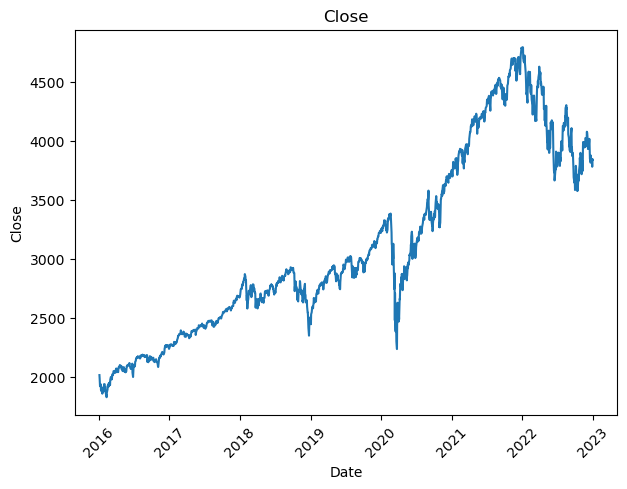

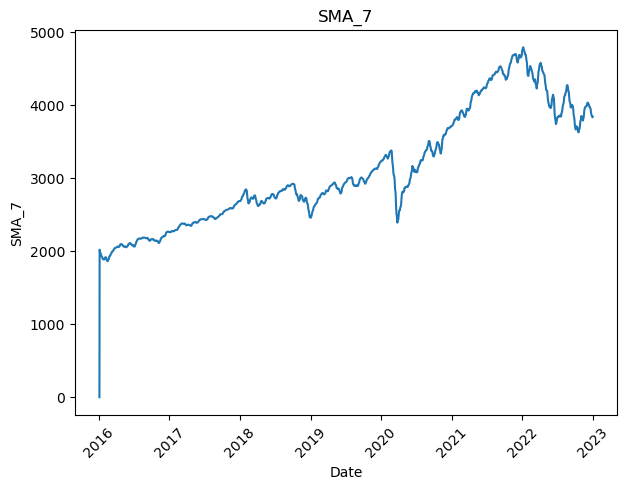

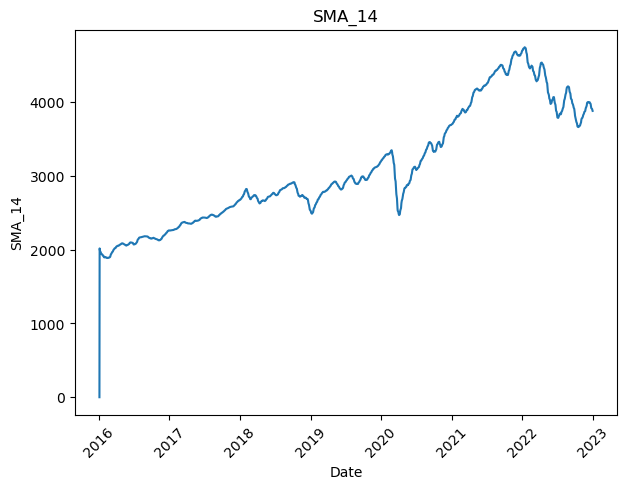

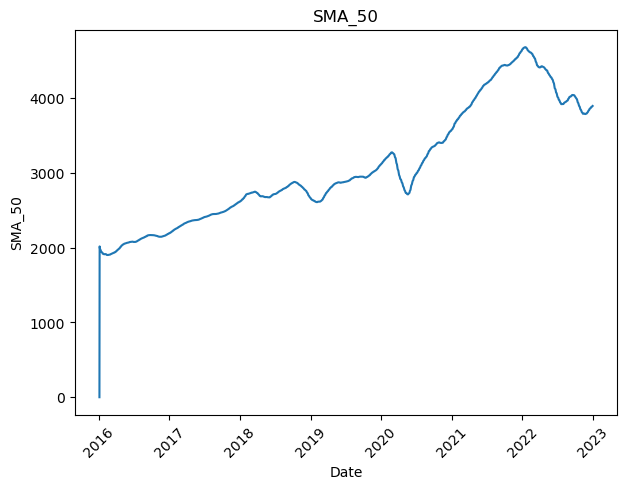

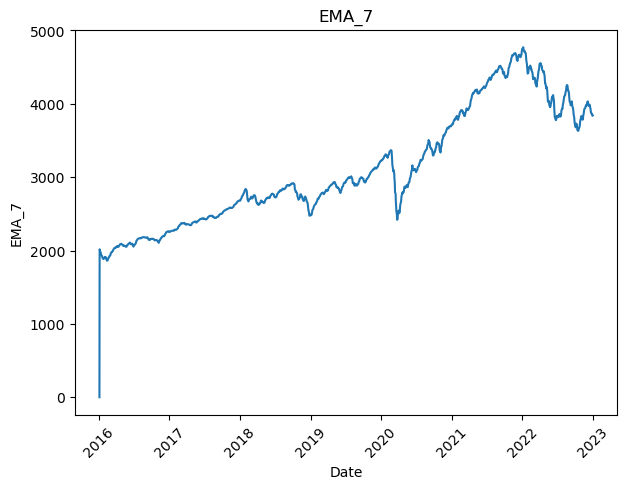

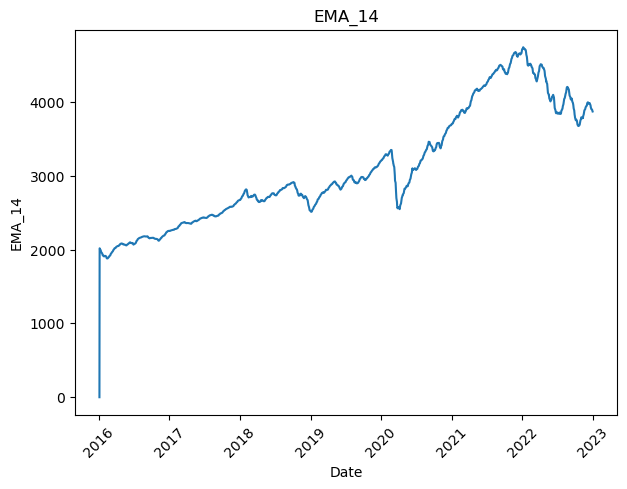

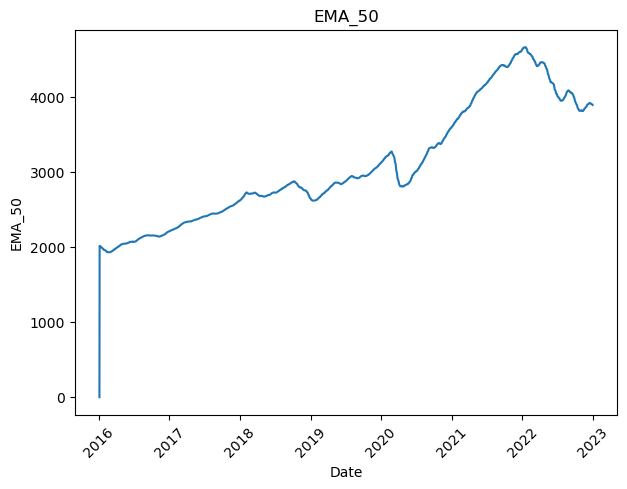

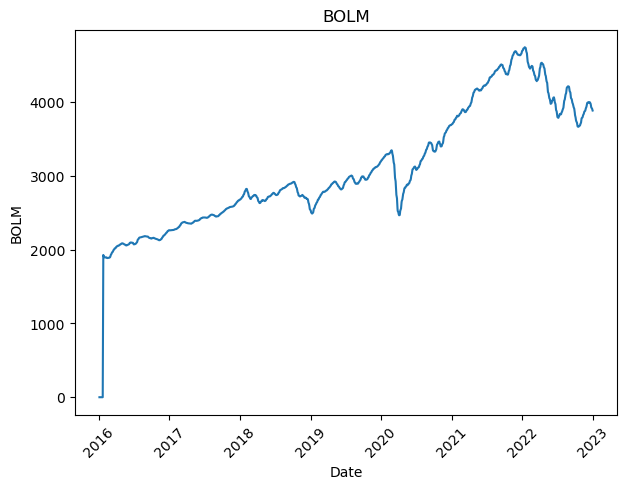

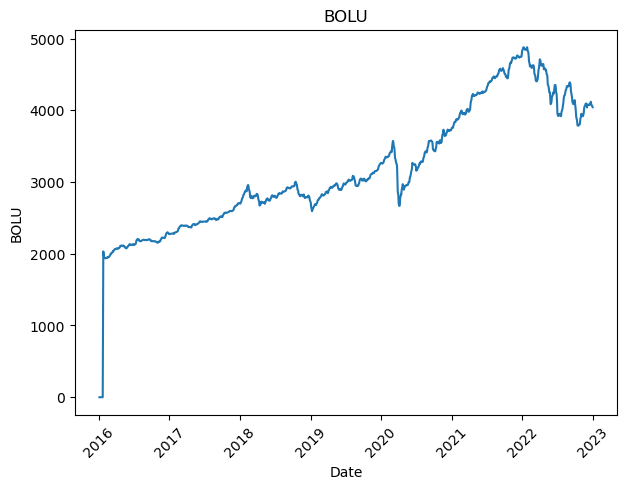

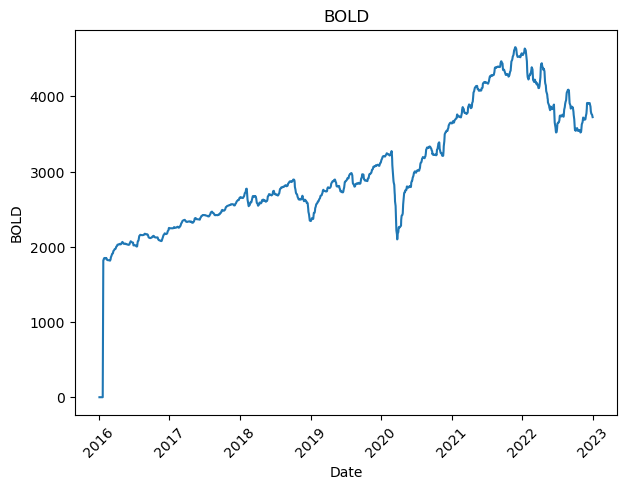

In [22]:
for feature in ['Close','SMA_7','SMA_14','SMA_50','EMA_7','EMA_14','EMA_50','BOLM','BOLU','BOLD']:
    plt.figure(figsize=(7,5))
    sns.lineplot(x=data['Date'], y=data[feature])
    plt.title(feature)
    plt.xticks(rotation=45)

**Candlestick Chart**

In [23]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
         open=data['Open'],
         high=data['High'],
         low=data['Low'],
         close=data['Close'])])

fig.update_layout(title='Candlestick Chart',xaxis_title='Date', yaxis_title='Price')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(width=600, height=500)
fig.show()

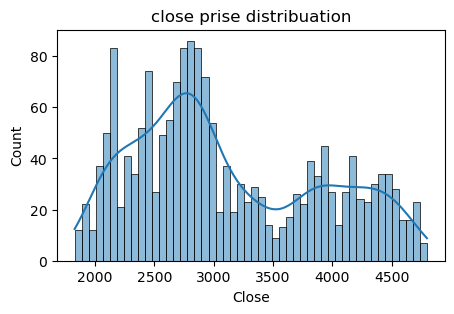

In [24]:
plt.figure(figsize=(5,3))
plt.title("close prise distribuation")
sns.histplot(data=data, x="Close", bins=50,kde=True)
plt.show()

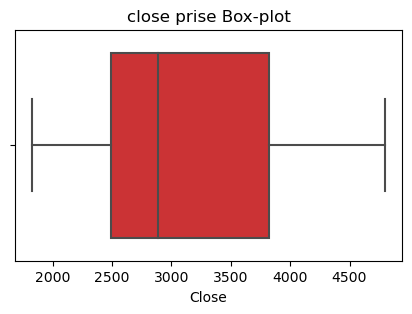

In [25]:
plt.figure(figsize=(5,3))
plt.title("close prise Box-plot")
sns.boxplot(data=data,x=data['Close'],palette='Set1')
plt.show()

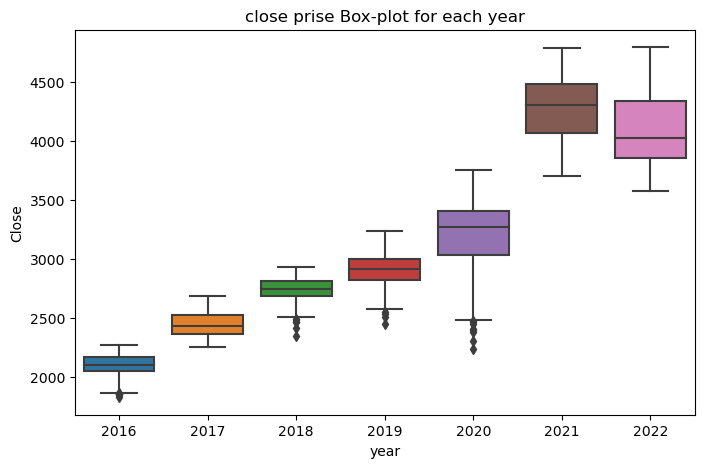

In [26]:
plt.figure(figsize=(8,5))
plt.title("close prise Box-plot for each year")
data['year'] = data['Date'].dt.year
sns.boxplot(x='year', y='Close', data=data)
#plt.title(company)
plt.show()
data.drop(['year'], axis=1, inplace=True)

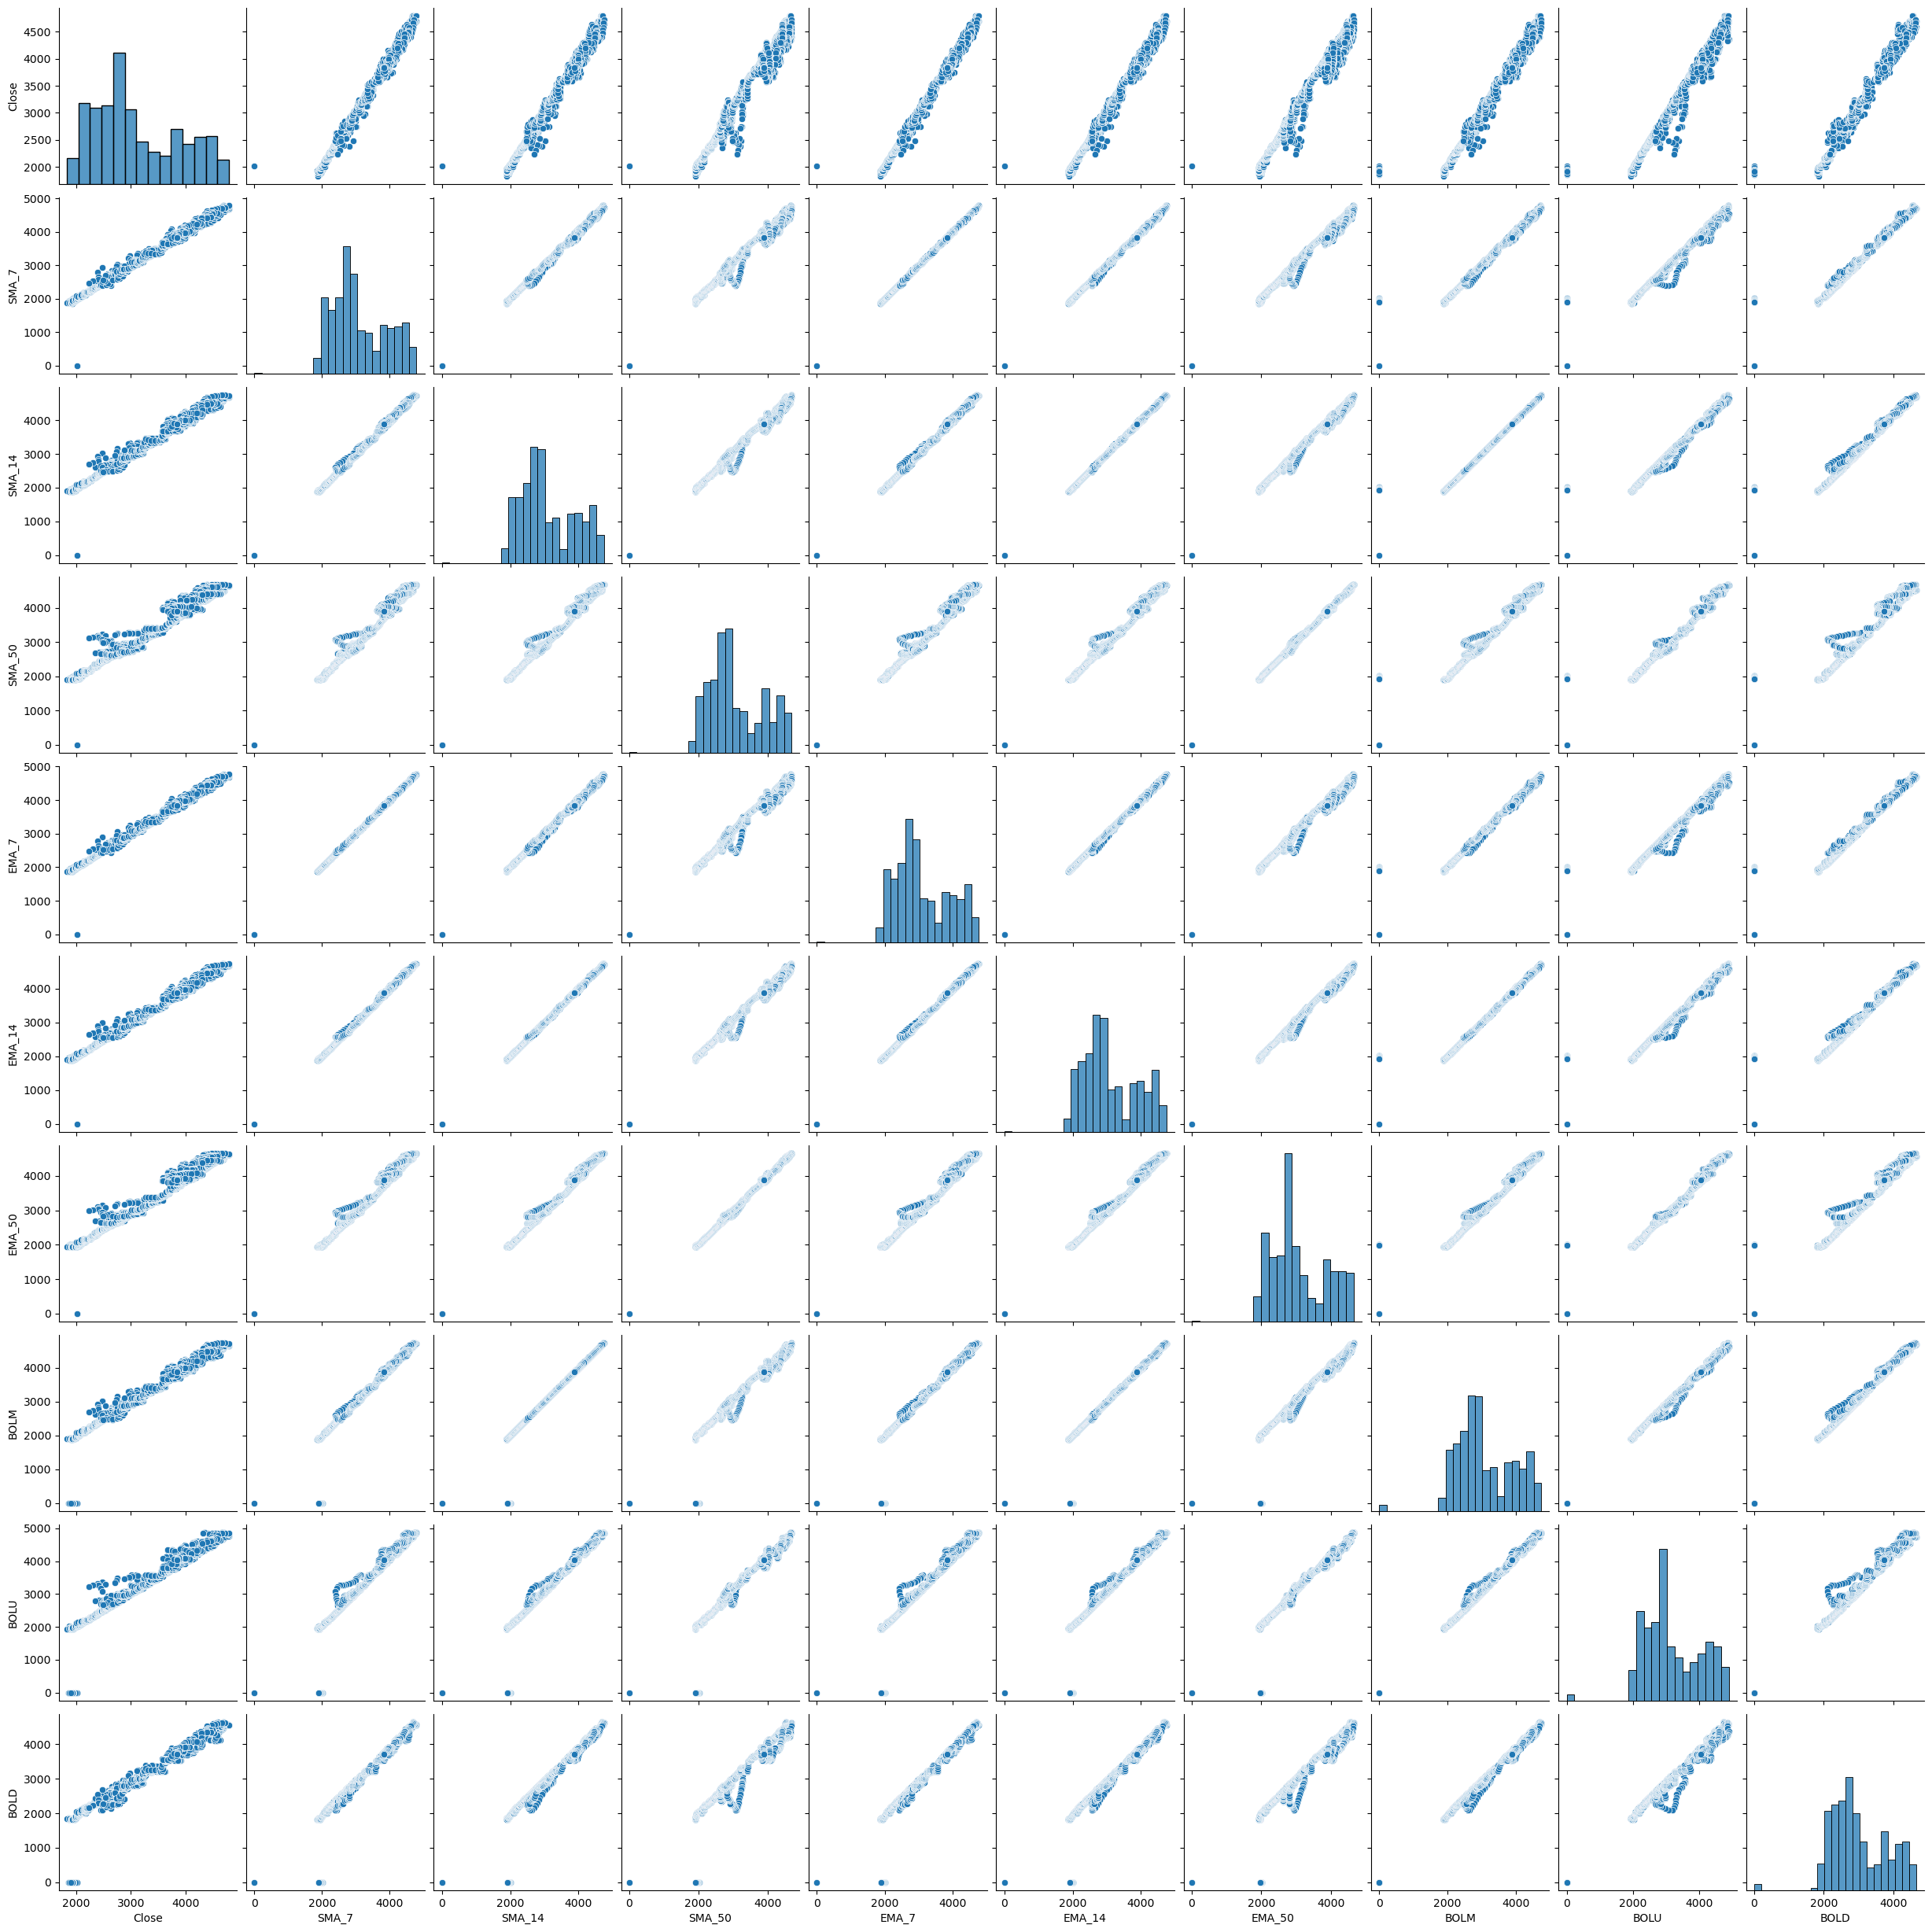

In [27]:
sns.pairplot(data[['Close','SMA_7','SMA_14','SMA_50','EMA_7','EMA_14','EMA_50','BOLM','BOLU','BOLD']])

### **<center>Correlations**

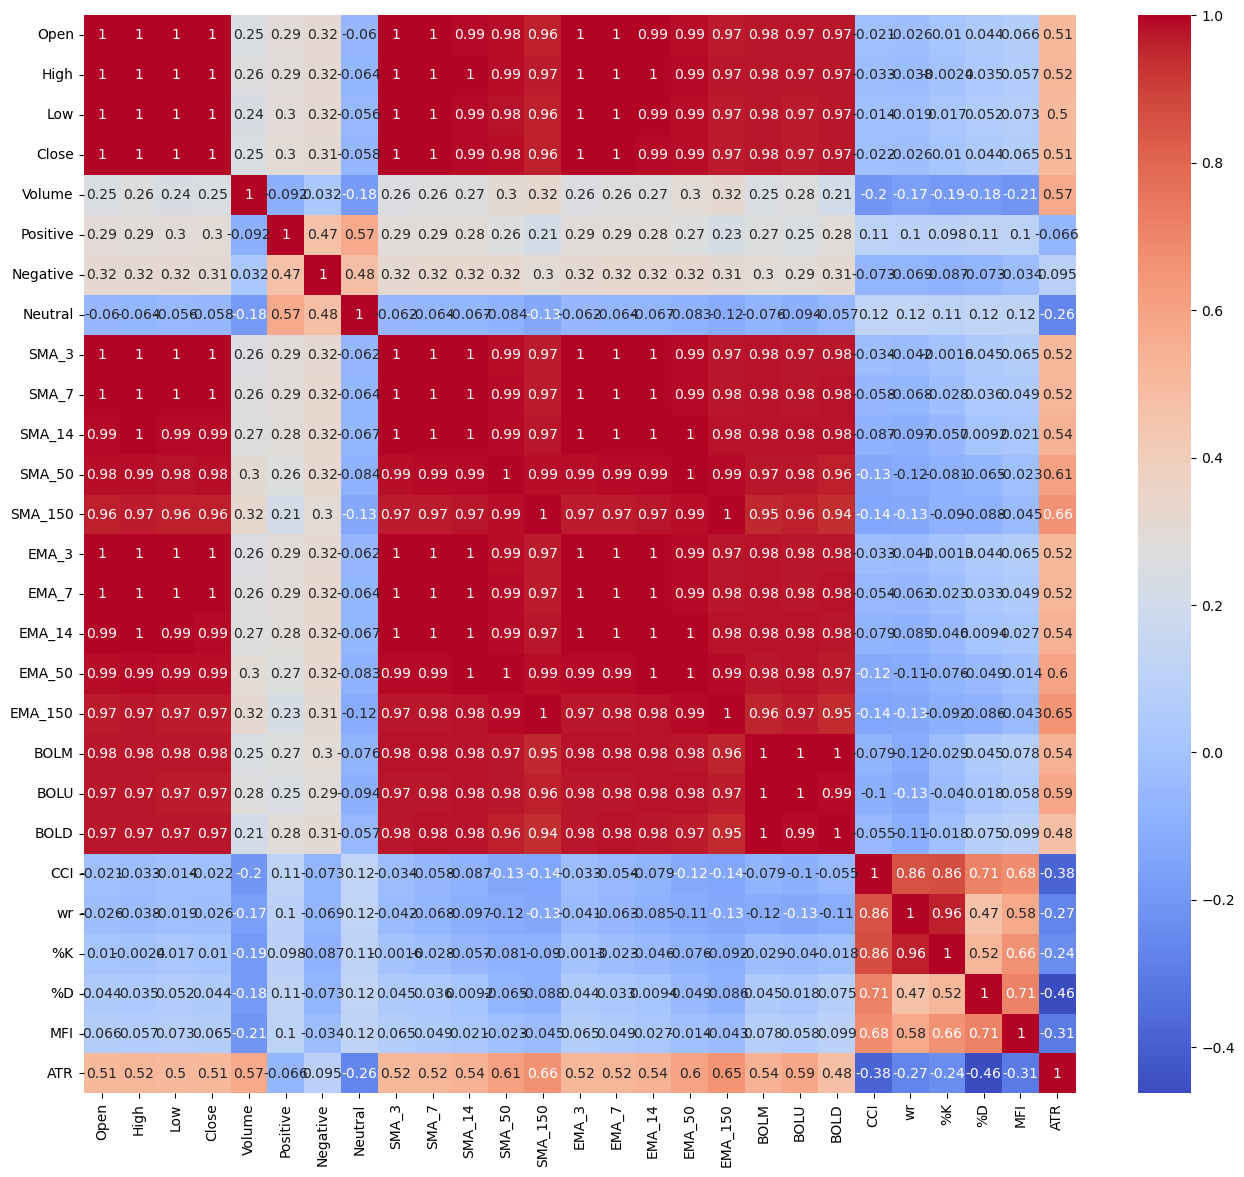

In [28]:
plt.figure(figsize=(16,14))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

**Map of extremely high correlations (above 0.95)**

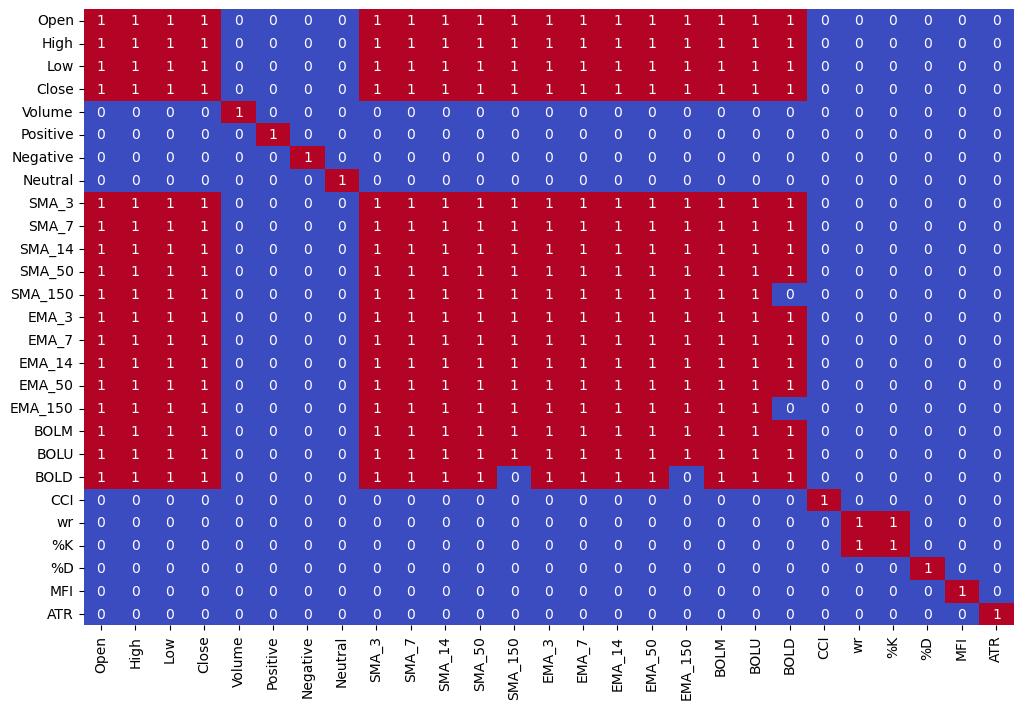

In [29]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr()>=0.95, annot=True, cmap='coolwarm',cbar=False)
plt.show()

**List of correlations in descending order**

In [30]:
data.corr()['Close'].sort_values(ascending=False)

Close       1.000000
Open        0.999256
Low         0.998569
High        0.998500
EMA_3       0.996672
SMA_3       0.996453
EMA_7       0.995740
SMA_7       0.995178
EMA_14      0.994057
SMA_14      0.992892
EMA_50      0.987012
SMA_50      0.983100
BOLM        0.975158
BOLD        0.973624
BOLU        0.971349
EMA_150     0.970329
SMA_150     0.963726
ATR         0.513448
Negative    0.311648
Positive    0.297744
Volume      0.247457
MFI         0.065112
%D          0.043569
%K          0.010199
CCI        -0.021788
wr         -0.025892
Neutral    -0.057837
Name: Close, dtype: float64

## <center>Data Preprocessing

### **Normality test and skewed features**

 In the field of machine learning, accurate and reliable models are essential for making meaningful predictions and understanding relationships within data. However, before applying machine learning models, it is crucial to examine the characteristics of the data to ensure the validity of the modeling process. Two important considerations are checking the normality of data and identifying skewed features. These steps play a vital role, especially in regression analysis, where understanding the distribution of variables can significantly impact the model's performance and interpretation.

**Importance of Checking Normality:**
Normality refers to the distribution of data points in a dataset. The assumption of normality is often made in various statistical techniques, including regression analysis. When the data follows a normal distribution, it exhibits a symmetric bell-shaped curve, which allows for certain statistical properties and simplifications. Checking the normality of data is crucial because:

1. Validity of Statistical Tests: Many statistical tests and assumptions, such as t-tests, ANOVA, and some regression techniques, assume that the data are normally distributed. Violating this assumption can lead to inaccurate results and incorrect interpretations of the model.

2. Model Performance: Regression models often assume that the residuals (the differences between the observed and predicted values) are normally distributed. Departure from normality can result in biased parameter estimates, incorrect p-values, and unreliable confidence intervals, which may compromise the model's predictive accuracy.

**Examining Skewed Features:**
Skewness measures the asymmetry of the distribution of a variable. Positive skewness indicates a longer right tail, while negative skewness indicates a longer left tail. Skewed features can introduce challenges in machine learning models, particularly in regression, due to the following reasons:

1. Impact on Assumptions: Skewed features can violate the assumption of linearity in regression models. Transforming skewed features using techniques like logarithmic or power transformations can help achieve linearity and improve model performance.

2. Influence on Predictions: Skewed features with outliers or extreme values can disproportionately affect the model's predictions. These outliers can lead to a model that is sensitive to a few extreme values, resulting in less accurate and robust predictions. 

In [31]:
def probplot(data,value):
    plt.figure(figsize=(7,4))
    sc.stats.probplot(value,dist="norm",plot=plt)
    plt.title("QQ test for normality distribution close")
    plt.legend(['Actual','Theoretical'])
    plt.show()

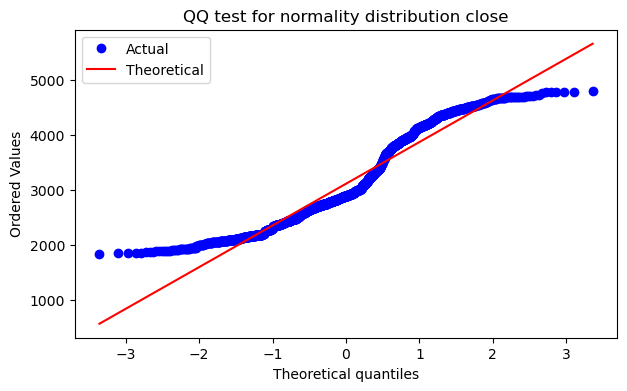

In [32]:
probplot(data,data['Close'])

### Dealing with skewed features

In [33]:
negative_features = []
for column in data.columns.drop('Date'):
    # Check if any value in the column is negative and skewed
    if (data[column] < 0).any() and skew(data[column]>60):
        negative_features.append(column)
for feature in negative_features:
    feature_values = data[feature]
    # Add a constant to make all values positive
    feature_positive = feature_values - np.min(feature_values) +1 
    # Apply boxcox transformation
    transformed_feature = boxcox1p(feature_positive, 0.15) 
    # Save the transformed feature back into the original DataFrame
    data[feature] = transformed_feature

#positive features:
negative_features.append('Date')
numeric_feats =data.columns.drop(negative_features)
count=0
for feat in numeric_feats:
    if skew(data[feat]>60):
        data[feat] = boxcox1p(data[feat], 0.15) 
        count=count+1
print(f"There are {count+len(negative_features)-1} skewed features")

There are 27 skewed features


**normality test after skewed data correction**

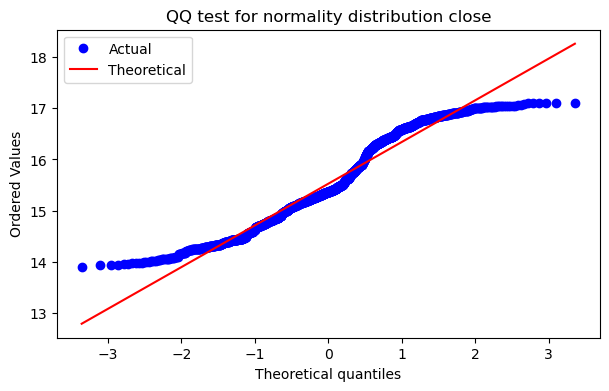

In [34]:
probplot(data,data['Close'])

## <center>Models

In [35]:
#model_evaluation
def MSE(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def MBE (y_true, y_pred):
    return np.mean(y_true - y_pred)
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def R2(y_true, y_pred):
    return r2_score(y_true, y_pred)
def model_evaluation(y_true, y_pred):
    return {'MSE': MSE(y_true, y_pred)[0], 'RMSE': RMSE(y_true, y_pred)[0], 'MAPE':MAPE(y_true, y_pred)[0],'MBE':MBE(y_true, y_pred)[0],
            "MAE":MAE(y_true, y_pred)[0],'R2': R2(y_true, y_pred)}

def data_prep(df):
    df=df.set_index('Date')
    x = df.drop(columns=['Close'], axis=1)
    y = pd.DataFrame(df['Close'])
    # Split the data into training and test sets
    X_train=x[:'2021-08-01']
    X_test=x['2021-08-01':]
    y_train=y[:'2021-08-01']
    y_test =y['2021-08-01':]
    #scalling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train=pd.DataFrame(X_train,columns=x.columns)
    X_test=pd.DataFrame(X_test,columns=x.columns)
   
    return X_train, X_test, y_train, y_test

#prediction vs actual plot
def Pred_Act_plot(predictions,model_name):
    print("model_evaluation:")
    print(model_evaluation(y_test,predictions))
    plt.plot(y_test['Close'].values,'r-',label='Actual')
    plt.plot(predictions,'b--',label='Predictions')
    plt.title(f"{model_name}-Predictions vs Actual Prices")
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [36]:
x_train, x_test, y_train, y_test = data_prep(data)

In [37]:
print("The size of the training set is: ", x_train.shape)
print("The size of the test set is: ", x_test.shape)
print("The size of the y training set is: ", y_train.shape)
print("The size of the y test set is: ", y_test.shape)

The size of the training set is:  (1403, 26)
The size of the test set is:  (358, 26)
The size of the y training set is:  (1403, 1)
The size of the y test set is:  (358, 1)


In [38]:
df=pd.DataFrame(columns=['Model','MSE','RMSE','MAPE','MBE','MAE','R2'])

### Linear Regression

model_evaluation:
{'MSE': 0.0015400910885836553, 'RMSE': 0.03924399429955691, 'MAPE': 0.18090207116923893, 'MBE': -0.0070846319130404315, 'MAE': 0.030005492212753053, 'R2': 0.9789596859968557}


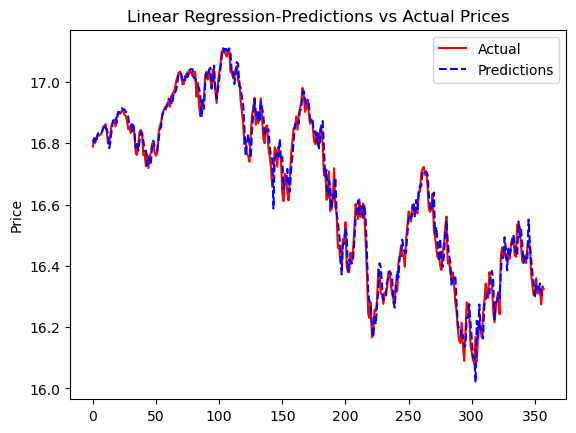

In [39]:
reg = LinearRegression()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)

Pred_Act_plot(predictions,'Linear Regression')
reg_evaluation=list(model_evaluation(y_test,predictions).values())
reg_evaluation.insert(0,'Linear Regression')
df.loc[len(df)]=reg_evaluation

### Ridge Regression

model_evaluation:
{'MSE': 0.0018500524830959782, 'RMSE': 0.04301223643448429, 'MAPE': 0.2028556368322736, 'MBE': 0.004280241435149161, 'MAE': 0.03367729022947369, 'R2': 0.9747250760327207}


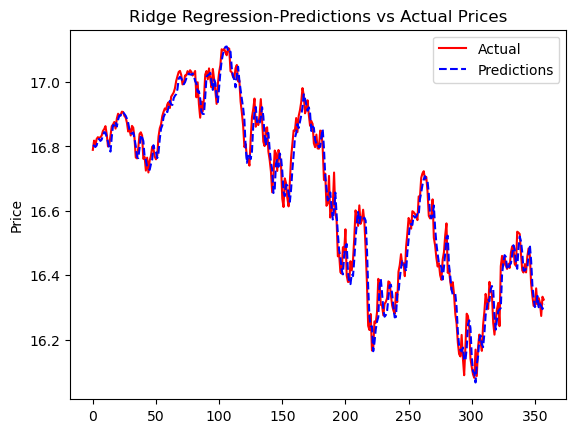

In [40]:
Ridge_Model = Ridge(alpha=1.0, random_state=42)
Ridge_Model.fit(x_train, y_train)
predictions = Ridge_Model.predict(x_test)

Pred_Act_plot(predictions,'Ridge Regression')
Ridge_evaluation=list(model_evaluation(y_test,predictions).values())
Ridge_evaluation.insert(0,'Ridge Regression')
df.loc[len(df)]=Ridge_evaluation


### Lasso Regression

model_evaluation:
{'MSE': 0.0016302098429887596, 'RMSE': 0.040375857179616136, 'MAPE': 0.1915711615329848, 'MBE': 0.008467825144284544, 'MAE': 0.03182513735592178, 'R2': 0.9777285075916878}


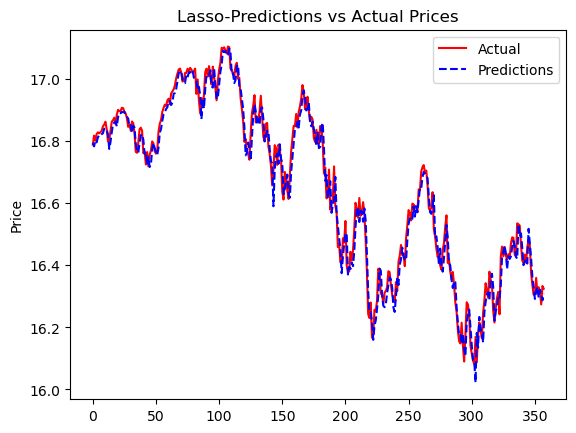

In [41]:
Lasso_Model = Lasso(alpha=0.001, random_state=42)
Lasso_Model.fit(x_train, y_train)
predictions = Lasso_Model.predict(x_test)

Pred_Act_plot(predictions.reshape(len(predictions),1),'Lasso')
Lasso_evaluation=list(model_evaluation(y_test,predictions.reshape(len(predictions),1)).values())
Lasso_evaluation.insert(0,'Lasso')
df.loc[len(df)]=Lasso_evaluation


### Random Forest Regression

Using grid-search to find the optimals paramethers

In [42]:
RFG_grid_run = False
if RFG_grid_run:
   ## Define Grid 
    grid = { 
        'n_estimators': [100, 200,300,400,500],
        'max_features': ['auto','sqrt','log2'],
        'max_depth' : [3,4,5,6,7],
        'random_state' : [18]
          }
    G_S = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
    G_S.fit(x_train, y_train)

In [43]:
#G_S.best_params_

 {'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 100,
 'random_state': 18}

model_evaluation:
{'MSE': 0.014175947211391768, 'RMSE': 0.11906278684539418, 'MAPE': 0.5586596183769708, 'MBE': 0.010753491435253391, 'MAE': 0.09328462641263575, 'R2': 0.8063319872242221}


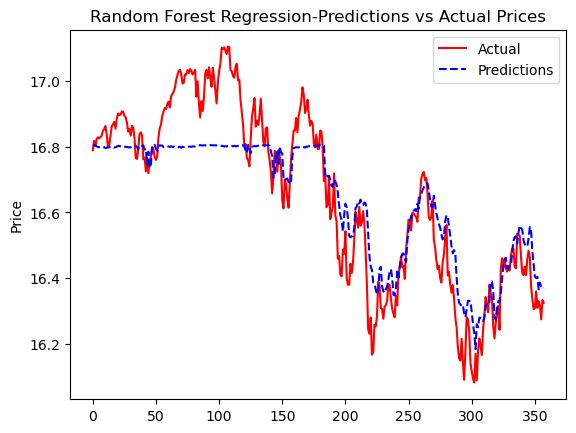

In [44]:
# Create and train model
if RFG_grid_run:
    rf = RandomForestRegressor(n_estimators = G_S.best_params_['n_estimators'], max_features = G_S.best_params_['max_features'],
    max_depth = G_S.best_params_['max_depth'],random_state=G_S.best_params_['random_state'])
else:    
    rf = RandomForestRegressor(n_estimators = 100, max_features ='auto' ,
         max_depth = 7,random_state=18)

rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

    
Pred_Act_plot(predictions.reshape(len(predictions),1),'Random Forest Regression')
RF_evaluation=list(model_evaluation(y_test,predictions.reshape(len(predictions),1)).values())
RF_evaluation.insert(0,'Random Forest Regression')
df.loc[len(df)]=RF_evaluation

### Elastic Net Regression

model_evaluation:
{'MSE': 0.002029725225470405, 'RMSE': 0.04505247191298614, 'MAPE': 0.21536424667599835, 'MBE': 0.00660522158849088, 'MAE': 0.035762656179684375, 'R2': 0.972270434910915}


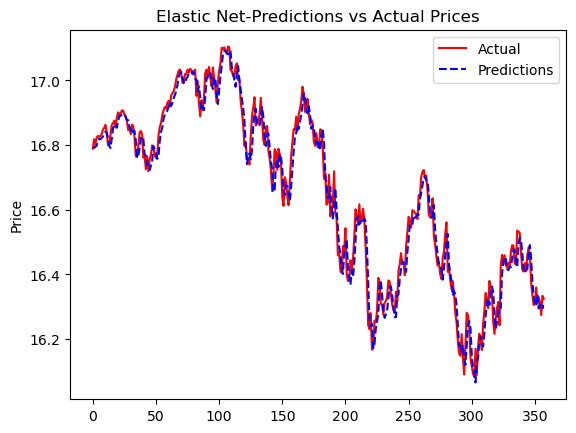

In [45]:
Elastic_Model = ElasticNet(alpha=0.001, random_state=42)
Elastic_Model.fit(x_train, y_train)
predictions = Elastic_Model.predict(x_test)

Pred_Act_plot(predictions.reshape(len(predictions),1),'Elastic Net')
Elastic_evaluation=list(model_evaluation(y_test,predictions.reshape(len(predictions),1)).values())
Elastic_evaluation.insert(0,'Elastic Net')
df.loc[len(df)]=Elastic_evaluation

### Support Vector Regression (SVM)

model_evaluation:
{'MSE': 0.004942131945141733, 'RMSE': 0.07030029832896681, 'MAPE': 0.33687313301001626, 'MBE': 0.016475400378871602, 'MAE': 0.05615154450887694, 'R2': 0.9324819104911635}


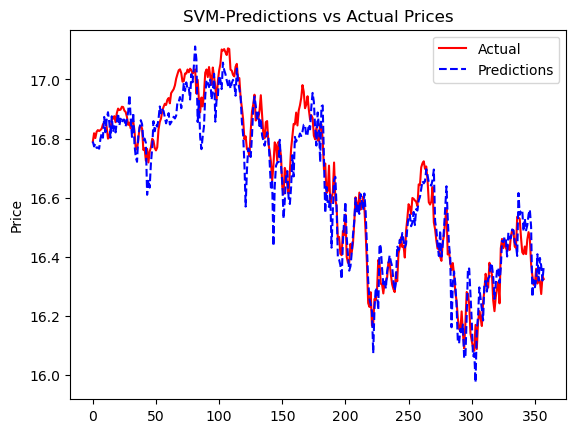

In [46]:
model = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

Pred_Act_plot(predictions.reshape(len(predictions),1),'SVM')
SVM_evaluation=list(model_evaluation(y_test,predictions.reshape(len(predictions),1)).values())
SVM_evaluation.insert(0,'SVM')
df.loc[len(df)]=SVM_evaluation

### XBoost

model_evaluation:
{'MSE': 0.011969704604719628, 'RMSE': 0.10940614518718603, 'MAPE': 0.47646421942279615, 'MBE': 0.043872778278711076, 'MAE': 0.08004047752373684, 'R2': 0.8364730857317055}


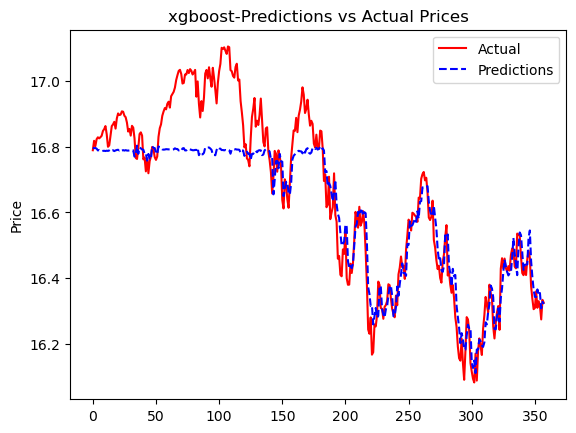

In [47]:
model = xg.XGBRegressor(n_estimators =1000,max_depth=5,learning_rate=0.01,n_jobs=-1,seed=27)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

Pred_Act_plot(predictions.reshape(len(predictions),1),'xgboost')
xgboost_evaluation=list(model_evaluation(y_test,predictions.reshape(len(predictions),1)).values())
xgboost_evaluation.insert(0,'xgboost Regression')
df.loc[len(df)]=xgboost_evaluation

### Artificial neural network (ANN)

In [48]:
ANN_model = Sequential()
ANN_model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
ANN_model.add(Dense(64,activation='relu'))
ANN_model.add(Dense(1,activation='linear'))
# Compile the model
ANN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])


ANN_model.fit(x_train, y_train, epochs=100, batch_size=32,verbose=0)
predictions = ANN_model.predict(x_test)
predictions = predictions.flatten()

12/12 [==============================] - 0s 1ms/step


model_evaluation:
{'MSE': 0.014110220396294804, 'RMSE': 0.1187864487064699, 'MAPE': 0.6324735633068532, 'MBE': -0.10299510166343162, 'MAE': 0.10492805450373092, 'R2': 0.8072299294552483}


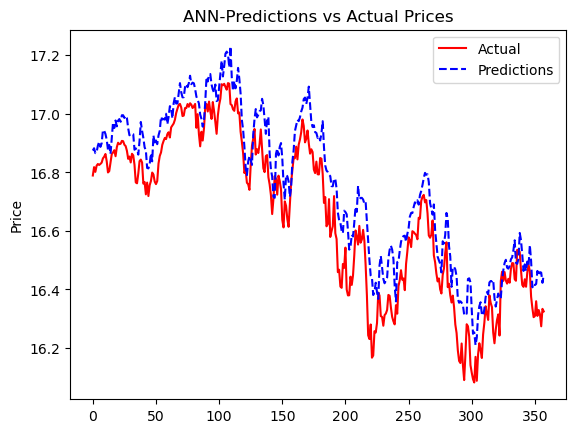

In [49]:
Pred_Act_plot(predictions.reshape(len(predictions),1),'ANN')
ANN_evaluation=list(model_evaluation(y_test,predictions.reshape(len(predictions),1)).values())
ANN_evaluation.insert(0,'ANN')
df.loc[len(df)]=ANN_evaluation

### LSTM 

In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], 1)))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')



12/12 [==============================] - 1s 11ms/step
model_evaluation:
{'MSE': 0.013877469943957364, 'RMSE': 0.11780267375555346, 'MAPE': 0.6122911636642273, 'MBE': 0.09253760386734233, 'MAE': 0.10208153762808048, 'R2': 0.8104097041048487}


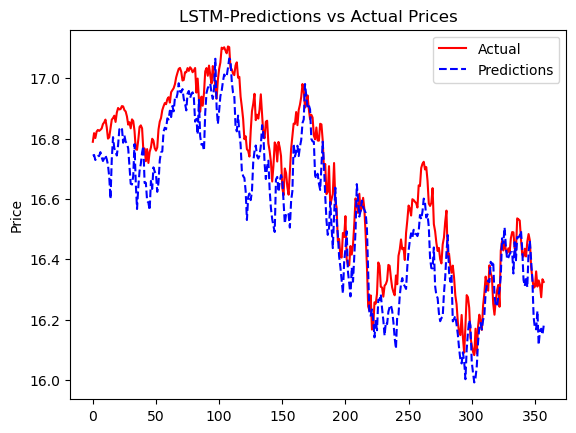

In [51]:
model.fit(x_train, y_train, epochs=100, batch_size=32,verbose=0)
predictions = model.predict(x_test)
predictions = predictions.flatten()

Pred_Act_plot(predictions.reshape(len(predictions),1),'LSTM')
LSTM_evaluation=list(model_evaluation(y_test,predictions.reshape(len(predictions),1)).values())
LSTM_evaluation.insert(0,'LSTM')
df.loc[len(df)]=LSTM_evaluation

## <center>Models Evaluation

In [52]:
df.set_index('Model')
df.sort_values(by=['RMSE'],ascending=True).reindex()

Model       MSE      RMSE      MAPE       MBE       MAE  \
0         Linear Regression  0.001540  0.039244  0.180902 -0.007085  0.030005   
2                     Lasso  0.001630  0.040376  0.191571  0.008468  0.031825   
1          Ridge Regression  0.001850  0.043012  0.202856  0.004280  0.033677   
4               Elastic Net  0.002030  0.045052  0.215364  0.006605  0.035763   
5                       SVM  0.004942  0.070300  0.336873  0.016475  0.056152   
6        xgboost Regression  0.011970  0.109406  0.476464  0.043873  0.080040   
8                      LSTM  0.013877  0.117803  0.612291  0.092538  0.102082   
7                       ANN  0.014110  0.118786  0.632474 -0.102995  0.104928   
3  Random Forest Regression  0.014176  0.119063  0.558660  0.010753  0.093285   

         R2  
0  0.978960  
2  0.977729  
1  0.974725  
4  0.972270  
5  0.932482  
6  0.836473  
8  0.810410  
7  0.807230  
3  0.806332

In [58]:
df.sort_values(by=['MSE'],ascending=True).reindex()

Model       MSE      RMSE      MAPE       MBE       MAE  \
0         Linear Regression  0.001540  0.039244  0.180902 -0.007085  0.030005   
2                     Lasso  0.001630  0.040376  0.191571  0.008468  0.031825   
1          Ridge Regression  0.001850  0.043012  0.202856  0.004280  0.033677   
4               Elastic Net  0.002030  0.045052  0.215364  0.006605  0.035763   
5                       SVM  0.004942  0.070300  0.336873  0.016475  0.056152   
6        xgboost Regression  0.011970  0.109406  0.476464  0.043873  0.080040   
8                      LSTM  0.013877  0.117803  0.612291  0.092538  0.102082   
7                       ANN  0.014110  0.118786  0.632474 -0.102995  0.104928   
3  Random Forest Regression  0.014176  0.119063  0.558660  0.010753  0.093285   

         R2  
0  0.978960  
2  0.977729  
1  0.974725  
4  0.972270  
5  0.932482  
6  0.836473  
8  0.810410  
7  0.807230  
3  0.806332

In [54]:
df.sort_values(by=['MAPE'],ascending=True).reindex()

Model       MSE      RMSE      MAPE       MBE       MAE  \
0         Linear Regression  0.001540  0.039244  0.180902 -0.007085  0.030005   
2                     Lasso  0.001630  0.040376  0.191571  0.008468  0.031825   
1          Ridge Regression  0.001850  0.043012  0.202856  0.004280  0.033677   
4               Elastic Net  0.002030  0.045052  0.215364  0.006605  0.035763   
5                       SVM  0.004942  0.070300  0.336873  0.016475  0.056152   
6        xgboost Regression  0.011970  0.109406  0.476464  0.043873  0.080040   
3  Random Forest Regression  0.014176  0.119063  0.558660  0.010753  0.093285   
8                      LSTM  0.013877  0.117803  0.612291  0.092538  0.102082   
7                       ANN  0.014110  0.118786  0.632474 -0.102995  0.104928   

         R2  
0  0.978960  
2  0.977729  
1  0.974725  
4  0.972270  
5  0.932482  
6  0.836473  
3  0.806332  
8  0.810410  
7  0.807230

In [55]:
df.sort_values(by=['MAE'],ascending=True).reindex()

Model       MSE      RMSE      MAPE       MBE       MAE  \
0         Linear Regression  0.001540  0.039244  0.180902 -0.007085  0.030005   
2                     Lasso  0.001630  0.040376  0.191571  0.008468  0.031825   
1          Ridge Regression  0.001850  0.043012  0.202856  0.004280  0.033677   
4               Elastic Net  0.002030  0.045052  0.215364  0.006605  0.035763   
5                       SVM  0.004942  0.070300  0.336873  0.016475  0.056152   
6        xgboost Regression  0.011970  0.109406  0.476464  0.043873  0.080040   
3  Random Forest Regression  0.014176  0.119063  0.558660  0.010753  0.093285   
8                      LSTM  0.013877  0.117803  0.612291  0.092538  0.102082   
7                       ANN  0.014110  0.118786  0.632474 -0.102995  0.104928   

         R2  
0  0.978960  
2  0.977729  
1  0.974725  
4  0.972270  
5  0.932482  
6  0.836473  
3  0.806332  
8  0.810410  
7  0.807230

In [59]:
df.sort_values(by=['MBE'],ascending=False).reindex()

Model       MSE      RMSE      MAPE       MBE       MAE  \
8                      LSTM  0.013877  0.117803  0.612291  0.092538  0.102082   
6        xgboost Regression  0.011970  0.109406  0.476464  0.043873  0.080040   
5                       SVM  0.004942  0.070300  0.336873  0.016475  0.056152   
3  Random Forest Regression  0.014176  0.119063  0.558660  0.010753  0.093285   
2                     Lasso  0.001630  0.040376  0.191571  0.008468  0.031825   
4               Elastic Net  0.002030  0.045052  0.215364  0.006605  0.035763   
1          Ridge Regression  0.001850  0.043012  0.202856  0.004280  0.033677   
0         Linear Regression  0.001540  0.039244  0.180902 -0.007085  0.030005   
7                       ANN  0.014110  0.118786  0.632474 -0.102995  0.104928   

         R2  
8  0.810410  
6  0.836473  
5  0.932482  
3  0.806332  
2  0.977729  
4  0.972270  
1  0.974725  
0  0.978960  
7  0.807230

In [56]:
df.sort_values(by=['R2'],ascending=False).reindex()

Model       MSE      RMSE      MAPE       MBE       MAE  \
0         Linear Regression  0.001540  0.039244  0.180902 -0.007085  0.030005   
2                     Lasso  0.001630  0.040376  0.191571  0.008468  0.031825   
1          Ridge Regression  0.001850  0.043012  0.202856  0.004280  0.033677   
4               Elastic Net  0.002030  0.045052  0.215364  0.006605  0.035763   
5                       SVM  0.004942  0.070300  0.336873  0.016475  0.056152   
6        xgboost Regression  0.011970  0.109406  0.476464  0.043873  0.080040   
8                      LSTM  0.013877  0.117803  0.612291  0.092538  0.102082   
7                       ANN  0.014110  0.118786  0.632474 -0.102995  0.104928   
3  Random Forest Regression  0.014176  0.119063  0.558660  0.010753  0.093285   

         R2  
0  0.978960  
2  0.977729  
1  0.974725  
4  0.972270  
5  0.932482  
6  0.836473  
8  0.810410  
7  0.807230  
3  0.806332

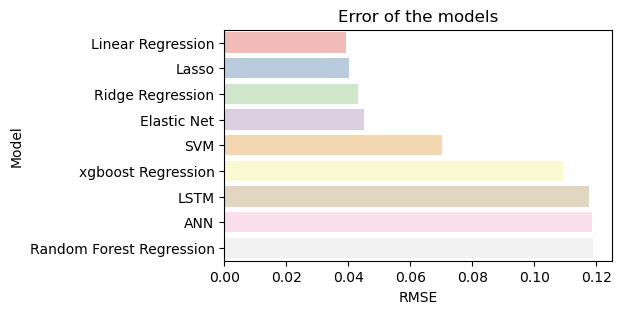

In [57]:
plt.figure(figsize=(5,3))
sns.barplot(x='RMSE', y='Model', data=df.sort_values(by=['RMSE']),palette='Pastel1')
plt.title('Error of the models')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.show()